# Homework 1

## Initialization

**Import libraries**

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader
from torch.backends import cudnn

from torchvision import transforms
from torchvision.models import alexnet, resnet50, vgg16
from torchvision.datasets import VisionDataset

from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt

from PIL import Image

import os
import os.path

**Set Argumets**

In [2]:
DEVICE = 'cuda'  # 'cuda' or 'cpu'

NUM_CLASSES = 101  # 101 + 1: There is am extra Background class that should be removed

BATCH_SIZE = (
    256  # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
)
# the batch size, learning rate should change by the same factor to have comparable results

LR = 1e-3  # The initial Learning Rate
MOMENTUM = 0.9  # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-5  # Regularization, you can keep this at the default

NUM_EPOCHS = 30  # Total number of training epochs (iterations over dataset)
STEP_SIZE = 15  # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.1  # Multiplicative factor for learning rate step-down

## Data Preparation


**Define Data Preprocessing**

In [3]:
# Define transforms for training phase
train_transform = transforms.Compose(
    [
        transforms.Resize(256),  # Resizes short size of the PIL image to 256
        transforms.CenterCrop(224),  # Crops a central square patch of the image
        # 224 because torchvision's AlexNet needs a 224x224 input!
        # Remember this when applying different transformations, otherwise you get an error
        transforms.ToTensor(),  # Turn PIL Image to torch.Tensor
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
        ),  # Normalizes tensor with alex net preprocessing
    ]
)
# Define transforms for the evaluation phase
eval_transform = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

**Prepare Dataset**

In [4]:
def pil_loader(path):
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')


class Caltech(VisionDataset):
    def __init__(self, root, split='train', transform=None, target_transform=None):
        super(Caltech, self).__init__(root, transform=transform, target_transform=target_transform)

        self.split = split  # This defines the split you are going to use
        # (split files are called 'train.txt' and 'test.txt')

        '''
        - Here you should implement the logic for reading the splits files and accessing elements
        - If the RAM size allows it, it is faster to store all data in memory
        - PyTorch Dataset classes use indexes to read elements
        - You should provide a way for the __getitem__ method to access the image-label pair
          through the index
        - Labels should start from 0, so for Caltech you will have lables 0...100 (excluding the background class)
        '''
        dir_list = os.listdir(root)
        dir_list.remove('BACKGROUND_Google')
        self.dataset = []
        self.labels = []
        with open(root + '../' + split + '.txt', 'r') as file:
            for line in file:
                for label, name in enumerate(dir_list):
                    if name + '/' in line:
                        self.dataset.append((pil_loader((root + line.strip())), label))
                        self.labels.append(label)
                        break

    def __getitem__(self, index):
        '''
        __getitem__ should access an element through its index
        Args:
            index (int): Index

        Returns:
            tuple: (sample, target) where target is class_index of the target class.
        '''

        image, label = self.dataset[index]  # Provide a way to access image and label via index
        # Image should be a PIL Image
        # label can be int

        # Applies preprocessing when accessing the image
        if self.transform is not None:
            image = self.transform(image)

        return image, label

    def __len__(self):
        '''
        The __len__ method returns the length of the dataset
        It is mandatory, as this is used by several other components
        '''
        length = len(self.dataset)  # Provide a way to get the length (number of elements) of the dataset
        return length

In [5]:
# Clone github repository with data
import pathlib
print(pathlib.Path().resolve())
if not os.path.isdir('./datasets/Caltech101'):
  !git clone https://github.com/MachineLearning2020/Homework2-Caltech101.git datasets/Caltech101

DATA_DIR = 'datasets/Caltech101/101_ObjectCategories/'

# Prepare Pytorch train/test Datasets
train_dataset = Caltech(DATA_DIR, split='train',  transform=train_transform)
test_dataset = Caltech(DATA_DIR, split='test', transform=eval_transform)


train_indexes, val_indexes, _, _ = train_test_split(range(len(train_dataset)), train_dataset.labels, test_size=0.25, random_state=0, stratify=train_dataset.labels)

val_dataset = Subset(train_dataset, val_indexes)
train_dataset = Subset(train_dataset, train_indexes)


# Check dataset sizes
print(f'Train Dataset: {len(train_dataset)}')
print(f'Valid Dataset: {(len(val_dataset))}')
print(f'Test Dataset: {len(test_dataset)}')

/content
Train Dataset: 4338
Valid Dataset: 1446
Test Dataset: 2893


**Prepare Dataloaders**

In [6]:
def create_dataloaders(batch_size):
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_dataloader, val_dataloader, test_dataloader

## Network Preparation

**Prepare Network**

In [ ]:
def get_alexnet(num_classes, pretrained=False):
    if pretrained:
        net = alexnet(weights='DEFAULT')
    else:
        net = alexnet()
    net.classifier[6] = nn.Linear(4096, num_classes)
    return net

**Prepare Training**

In [7]:
def prepare_training(net, lr, momentum, weight_decay, step_size, gamma, trainable='all'):
    if trainable == 'fc':
        parameters_to_optimize = net.classifier.parameters()
    elif trainable == 'conv':
        parameters_to_optimize = net.features.parameters()
    else:
        parameters_to_optimize = net.parameters()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(parameters_to_optimize, lr=lr, momentum=momentum, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    return criterion, optimizer, scheduler

**Train and Validation**

In [8]:
def training_and_validation(
    net, train_dataloader, val_dataloader, criterion, optimizer, scheduler, device, num_epochs, pasience=5
):
    # By default, everything is loaded to cpu
    net = net.to(device)  # this will bring the network to GPU if DEVICE is cuda
    state = net.state_dict()

    cudnn.benchmark  # Calling this optimizes runtime

    # Arrays to save metrics during the training
    history_train_loss = []
    history_train_acc = []
    history_val_loss = []
    history_val_acc = []

    # For early stopping
    no_improvment = 0
    min_loss = float('inf')

    # Start iterating over the epochs
    for epoch in tqdm(range(num_epochs)):
        tot_train_loss, tot_train_samples = 0.0, 0
        tot_val_loss = 0.0
        running_corrects = 0

        net.train()
        print(f'Starting epoch {epoch + 1}/{num_epochs}, LR = {scheduler.get_last_lr()}')

        # Iterate over the dataset
        for images, labels in train_dataloader:
            # Bring data over the device of choice
            images = images.to(device)
            labels = labels.to(device)

            tot_train_samples += images.size(0)

            # PyTorch, by default, accumulates gradients after each backward pass
            # We need to manually set the gradients to zero before starting a new iteration
            optimizer.zero_grad()  # Zero-ing the gradients

            # Forward pass to the network
            outputs = net(images)

            # Compute loss based on output and ground truth
            loss = criterion(outputs, labels)

            # Accumulate loss
            tot_train_loss += loss.item() * images.size(0)

            # Get predictions
            _, preds = torch.max(outputs.data, 1)

            # Update Corrects
            running_corrects += torch.sum(preds == labels.data).data.item()

            # Compute gradients for each layer and update weights
            loss.backward()  # backward pass: computes gradients
            optimizer.step()  # update weights based on accumulated gradients

        # Step the scheduler
        scheduler.step()

        # Calculate Metrics
        train_acc = running_corrects / float(tot_train_samples)
        train_loss = tot_train_loss / float(tot_train_samples)

        print(f'Training Loss: {train_loss:3f}, Training Accuracy: {train_acc:3f}')

        net.train(False)  # Set Network to evaluation mode

        running_corrects = 0
        for images, labels in val_dataloader:
            images = images.to(device)
            labels = labels.to(device)

            # Forward Pass
            outputs = net(images)

            # Compute loss based on output and ground truth
            loss = criterion(outputs, labels)

            # Accumulate loss
            tot_val_loss += loss.item() * images.size(0)

            # Get predictions
            _, preds = torch.max(outputs.data, 1)

            # Update Corrects
            running_corrects += torch.sum(preds == labels.data).data.item()

        # Calculate Metrics
        val_loss = tot_val_loss / float(len(val_dataset))
        val_acc = running_corrects / float(len(val_dataset))

        print(f'Validation Loss: {val_loss:3f}, Validation Accuracy: {val_acc:3f}')

        history_train_loss.append(train_loss)
        history_train_acc.append(train_acc)
        history_val_loss.append(val_loss)
        history_val_acc.append(val_acc)

        # check pacience for early stopping,and update best model
        if val_loss < min_loss:
            min_loss = val_loss
            no_improvment = 0
            state = net.state_dict()
        else:
            no_improvment += 1
            if no_improvment == pasience:
                print('Stopped with early stopping')
                return state, {
                    'train_loss': history_train_loss,
                    'train_acc': history_train_acc,
                    'val_loss': history_val_loss,
                    'val_acc': history_val_acc,
                }

    return state, {
        'train_loss': history_train_loss,
        'train_acc': history_train_acc,
        'val_loss': history_val_loss,
        'val_acc': history_val_acc,
    }

**Test**

In [9]:
def test(net, test_dataloader, device):
    net = net.to(device)  # this will bring the network to GPU if device is cuda
    net.train(False)  # Set Network to evaluation mode

    running_corrects = 0
    for images, labels in tqdm(test_dataloader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward Pass
        outputs = net(images)

        # Get predictions
        _, preds = torch.max(outputs.data, 1)

        # Update Corrects
        running_corrects += torch.sum(preds == labels.data).data.item()

    # Calculate Accuracy
    accuracy = running_corrects / float(len(test_dataset))

    print('Test Accuracy: {}'.format(accuracy))

**Plotting Metrics**

In [10]:
def show_graphics(history):
    best_loss = min(history['val_loss'])

    # plot loss
    plt.plot(range(len(history['train_loss'])), history['train_loss'], label='Training')
    plt.plot(range(len(history['val_loss'])), history['val_loss'], label='Validation')
    plt.plot(history['val_loss'].index(best_loss), best_loss, marker='X', color='blue', label='Best Model')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    # plot accuracy
    plt.plot(range(len(history['train_acc'])), history['train_acc'], label='Training')
    plt.plot(range(len(history['val_acc'])), history['val_acc'], label='Validation')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

## Experiment

### Train from scratch

#### Experiment 1

Use a not pretrained AlexNet, and training on all the parameters

In [ ]:
# changing some iper-parameters
BATCH_SIZE = 128
LR = 1e-2
NUM_EPOCHS = 45
STEP_SIZE = 20
GAMMA = 0.1

train_dataloader, val_dataloader, test_dataloader = create_dataloaders(BATCH_SIZE)
net = get_alexnet(NUM_CLASSES)
criterion, optimizer, scheduler = prepare_training(net, LR, MOMENTUM, WEIGHT_DECAY, STEP_SIZE, GAMMA, trainable='all')

best_state_dict, history = training_and_validation(
    net, train_dataloader, val_dataloader, criterion, optimizer, scheduler, DEVICE, NUM_EPOCHS, pasience=7
)

# load best state of training
net.load_state_dict(best_state_dict)

  0%|          | 0/45 [00:00<?, ?it/s]

Starting epoch 1/45, LR = [0.01]
Training Loss: 4.506295, Training Accuracy: 0.080256
Validation Loss: 4.343672, Validation Accuracy: 0.092669
Starting epoch 2/45, LR = [0.01]
Training Loss: 4.201583, Training Accuracy: 0.093277
Validation Loss: 4.118307, Validation Accuracy: 0.091978
Starting epoch 3/45, LR = [0.01]
Training Loss: 4.052513, Training Accuracy: 0.132812
Validation Loss: 3.931870, Validation Accuracy: 0.183956
Starting epoch 4/45, LR = [0.01]
Training Loss: 3.874290, Training Accuracy: 0.185133
Validation Loss: 3.677783, Validation Accuracy: 0.206086
Starting epoch 5/45, LR = [0.01]
Training Loss: 3.676942, Training Accuracy: 0.213778
Validation Loss: 3.496253, Validation Accuracy: 0.250346
Starting epoch 6/45, LR = [0.01]
Training Loss: 3.404900, Training Accuracy: 0.258759
Validation Loss: 3.307737, Validation Accuracy: 0.280775
Starting epoch 7/45, LR = [0.01]
Training Loss: 3.170871, Training Accuracy: 0.296165
Validation Loss: 2.994974, Validation Accuracy: 0.336791

<All keys matched successfully>

Showing Results

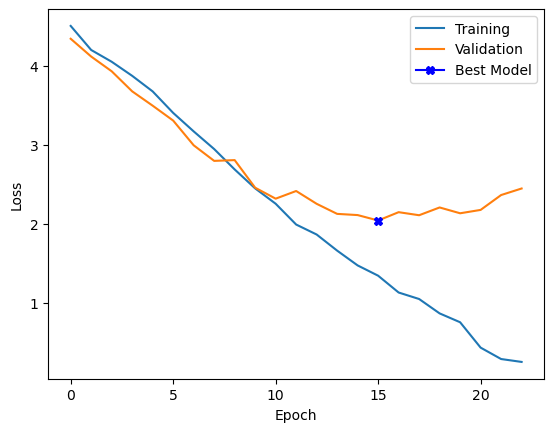

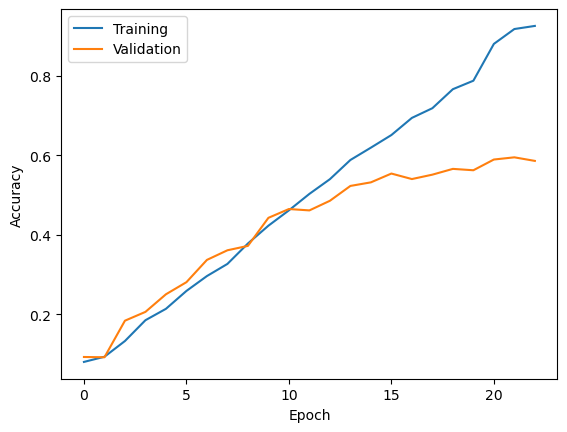

  0%|          | 0/23 [00:00<?, ?it/s]

Test Accuracy: 0.6083650190114068


In [ ]:
show_graphics(history)
test(net, test_dataloader, DEVICE)

#### Experiment 2

Use a not pretrained AlexNet, and training on all the parameters (changing iper-parameters)

In [ ]:
# changing some iper-parameters
BATCH_SIZE = 256
LR = 1e-2
NUM_EPOCHS = 45
STEP_SIZE = 15
GAMMA = 0.1

train_dataloader, val_dataloader, test_dataloader = create_dataloaders(BATCH_SIZE)
net = get_alexnet(NUM_CLASSES)
criterion, optimizer, scheduler = prepare_training(net, LR, MOMENTUM, WEIGHT_DECAY, STEP_SIZE, GAMMA, trainable='all')

best_state_dict, history = training_and_validation(
    net, train_dataloader, val_dataloader, criterion, optimizer, scheduler, DEVICE, NUM_EPOCHS, pasience=7
)

# load best state of training
net.load_state_dict(best_state_dict)

  0%|          | 0/45 [00:00<?, ?it/s]

Starting epoch 1/45, LR = [0.01]
Training Loss: 4.599976, Training Accuracy: 0.064697
Validation Loss: 4.573748, Validation Accuracy: 0.091978
Starting epoch 2/45, LR = [0.01]
Training Loss: 4.416249, Training Accuracy: 0.084229
Validation Loss: 4.256341, Validation Accuracy: 0.061549
Starting epoch 3/45, LR = [0.01]
Training Loss: 4.209408, Training Accuracy: 0.094971
Validation Loss: 4.173829, Validation Accuracy: 0.091978
Starting epoch 4/45, LR = [0.01]
Training Loss: 4.136115, Training Accuracy: 0.100586
Validation Loss: 4.082702, Validation Accuracy: 0.143845
Starting epoch 5/45, LR = [0.01]
Training Loss: 4.040952, Training Accuracy: 0.137695
Validation Loss: 3.976545, Validation Accuracy: 0.159751
Starting epoch 6/45, LR = [0.01]
Training Loss: 3.940778, Training Accuracy: 0.164062
Validation Loss: 3.894741, Validation Accuracy: 0.207469
Starting epoch 7/45, LR = [0.01]
Training Loss: 3.827117, Training Accuracy: 0.209717
Validation Loss: 3.713408, Validation Accuracy: 0.228216

<All keys matched successfully>

Showing Results

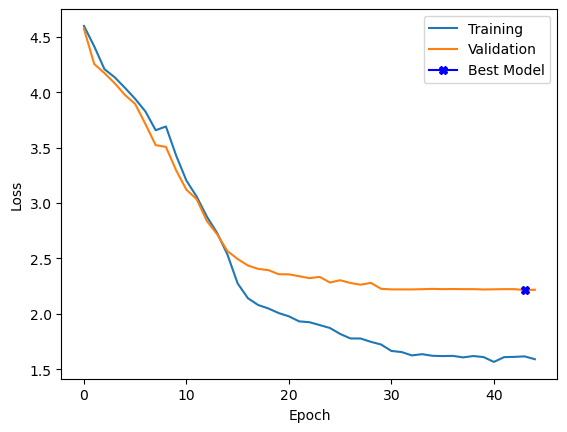

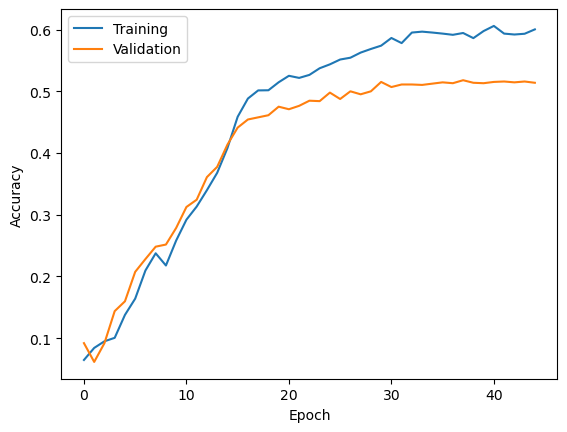

  0%|          | 0/12 [00:00<?, ?it/s]

Test Accuracy: 0.5212582094711372


In [ ]:
show_graphics(history)
test(net, test_dataloader, DEVICE)

#### Experiment 3

Use a not pretrained AlexNet, and training on all the parameters (changing iper-parameters)

In [ ]:
# changing some iper-parameters
BATCH_SIZE = 512
LR = 1e-2
NUM_EPOCHS = 45
STEP_SIZE = 25
GAMMA = 0.1

train_dataloader, val_dataloader, test_dataloader = create_dataloaders(BATCH_SIZE)
net = get_alexnet(NUM_CLASSES)
criterion, optimizer, scheduler = prepare_training(net, LR, MOMENTUM, WEIGHT_DECAY, STEP_SIZE, GAMMA, trainable='all')

best_state_dict, history = training_and_validation(
    net, train_dataloader, val_dataloader, criterion, optimizer, scheduler, DEVICE, NUM_EPOCHS, pasience=7
)

# load best state of training
net.load_state_dict(best_state_dict)

  0%|          | 0/45 [00:00<?, ?it/s]

Starting epoch 1/45, LR = [0.01]
Training Loss: 4.610933, Training Accuracy: 0.031982
Validation Loss: 4.602376, Validation Accuracy: 0.091978
Starting epoch 2/45, LR = [0.01]
Training Loss: 4.591800, Training Accuracy: 0.091309
Validation Loss: 4.575430, Validation Accuracy: 0.091978
Starting epoch 3/45, LR = [0.01]
Training Loss: 4.542494, Training Accuracy: 0.092529
Validation Loss: 4.465095, Validation Accuracy: 0.091978
Starting epoch 4/45, LR = [0.01]
Training Loss: 4.325397, Training Accuracy: 0.091309
Validation Loss: 4.278119, Validation Accuracy: 0.092669
Starting epoch 5/45, LR = [0.01]
Training Loss: 4.228375, Training Accuracy: 0.095947
Validation Loss: 4.198109, Validation Accuracy: 0.091978
Starting epoch 6/45, LR = [0.01]
Training Loss: 4.190556, Training Accuracy: 0.092285
Validation Loss: 4.165223, Validation Accuracy: 0.141770
Starting epoch 7/45, LR = [0.01]
Training Loss: 4.141880, Training Accuracy: 0.104004
Validation Loss: 4.112229, Validation Accuracy: 0.100277

<All keys matched successfully>

Showing Results

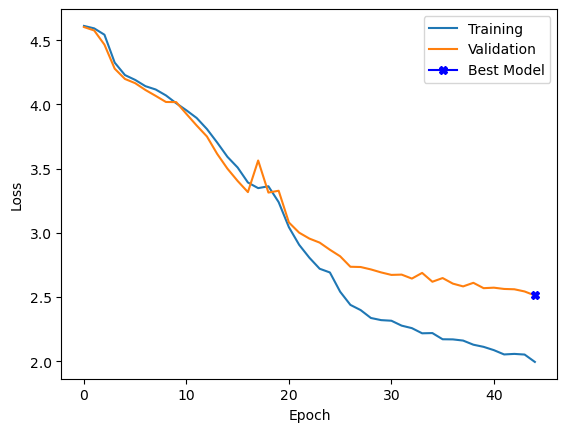

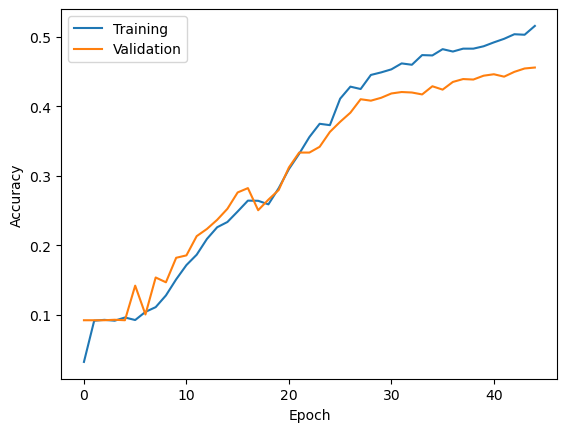

  0%|          | 0/6 [00:00<?, ?it/s]

Test Accuracy: 0.455928102315935


In [ ]:
show_graphics(history)
test(net, test_dataloader, DEVICE)

### Transfer Learning

#### Experiment 1

Use pre trained AlexNet, training on all the parameters

In [ ]:
# changing some iper-parameters
BATCH_SIZE = 512
LR = 1e-2
NUM_EPOCHS = 30
STEP_SIZE = 10
GAMMA = 0.1

# initialitation of dataloader, net and training
train_dataloader, val_dataloader, test_dataloader = create_dataloaders(BATCH_SIZE)
net = get_alexnet(NUM_CLASSES, pretrained=True)
criterion, optimizer, scheduler = prepare_training(net, LR, MOMENTUM, WEIGHT_DECAY, STEP_SIZE, GAMMA, trainable='all')

# training and validation
best_state_dict, history = training_and_validation(
    net, train_dataloader, val_dataloader, criterion, optimizer, scheduler, DEVICE, NUM_EPOCHS, pasience=10
)

# load best state of training
net.load_state_dict(best_state_dict)

  0%|          | 0/30 [00:00<?, ?it/s]

Starting epoch 1/30, LR = [0.01]
Training Loss: 3.325372, Training Accuracy: 0.298584
Validation Loss: 2.021503, Validation Accuracy: 0.569848
Starting epoch 2/30, LR = [0.01]
Training Loss: 1.348866, Training Accuracy: 0.671631
Validation Loss: 0.852809, Validation Accuracy: 0.768326
Starting epoch 3/30, LR = [0.01]
Training Loss: 0.522108, Training Accuracy: 0.852051
Validation Loss: 0.608700, Validation Accuracy: 0.828492
Starting epoch 4/30, LR = [0.01]
Training Loss: 0.299960, Training Accuracy: 0.914551
Validation Loss: 0.565093, Validation Accuracy: 0.846473
Starting epoch 5/30, LR = [0.01]
Training Loss: 0.170257, Training Accuracy: 0.949707
Validation Loss: 0.564439, Validation Accuracy: 0.857538
Starting epoch 6/30, LR = [0.01]
Training Loss: 0.103600, Training Accuracy: 0.967041
Validation Loss: 0.564897, Validation Accuracy: 0.870678
Starting epoch 7/30, LR = [0.01]
Training Loss: 0.064991, Training Accuracy: 0.980957
Validation Loss: 0.572676, Validation Accuracy: 0.852697

<All keys matched successfully>

Showing Results

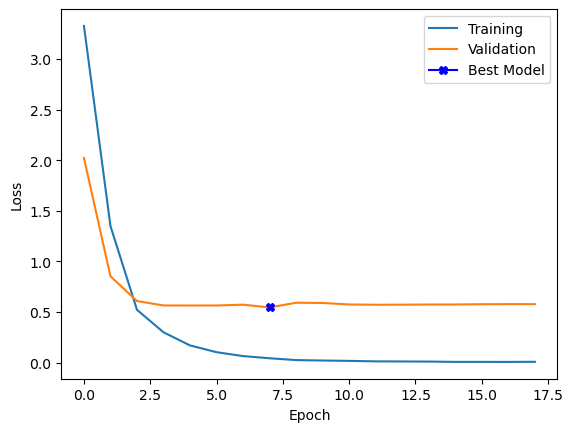

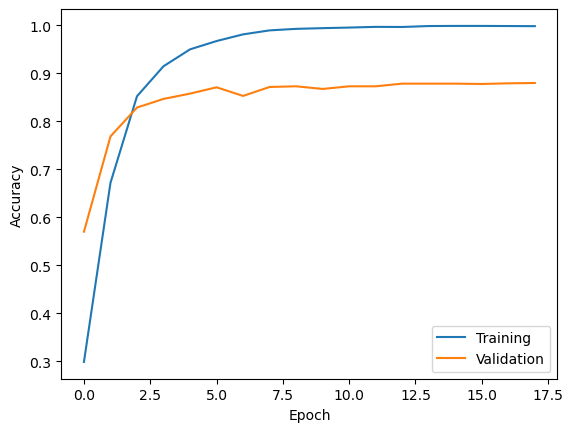

  0%|          | 0/6 [00:00<?, ?it/s]

Test Accuracy: 0.8686484618043553


In [ ]:
show_graphics(history)
test(net, test_dataloader, DEVICE)

#### Experiment 2

Use pre trained AlexNet, training on all the parameters (changing iper-parameters)

In [ ]:
# changing some iper-parameters
BATCH_SIZE = 256
LR = 1e-3
NUM_EPOCHS = 40
STEP_SIZE = 10
GAMMA = 0.1

# initialitation of dataloader, net and training
train_dataloader, val_dataloader, test_dataloader = create_dataloaders(BATCH_SIZE)
net = get_alexnet(NUM_CLASSES, pretrained=True)
criterion, optimizer, scheduler = prepare_training(net, LR, MOMENTUM, WEIGHT_DECAY, STEP_SIZE, GAMMA, trainable='all')

# training and validation
best_state_dict, history = training_and_validation(
    net, train_dataloader, val_dataloader, criterion, optimizer, scheduler, DEVICE, NUM_EPOCHS, pasience=7
)

# load best state of training
net.load_state_dict(best_state_dict)

  0%|          | 0/40 [00:00<?, ?it/s]

Starting epoch 1/40, LR = [0.001]
Training Loss: 3.885271, Training Accuracy: 0.199951
Validation Loss: 2.854695, Validation Accuracy: 0.374136
Starting epoch 2/40, LR = [0.001]
Training Loss: 2.363485, Training Accuracy: 0.478516
Validation Loss: 1.857248, Validation Accuracy: 0.595436
Starting epoch 3/40, LR = [0.001]
Training Loss: 1.407414, Training Accuracy: 0.662109
Validation Loss: 1.104224, Validation Accuracy: 0.730290
Starting epoch 4/40, LR = [0.001]
Training Loss: 0.791177, Training Accuracy: 0.794189
Validation Loss: 0.773878, Validation Accuracy: 0.793914
Starting epoch 5/40, LR = [0.001]
Training Loss: 0.505183, Training Accuracy: 0.858154
Validation Loss: 0.700737, Validation Accuracy: 0.802905
Starting epoch 6/40, LR = [0.001]
Training Loss: 0.346662, Training Accuracy: 0.904053
Validation Loss: 0.619406, Validation Accuracy: 0.827801
Starting epoch 7/40, LR = [0.001]
Training Loss: 0.258177, Training Accuracy: 0.926270
Validation Loss: 0.596747, Validation Accuracy: 0

<All keys matched successfully>

Showing Results

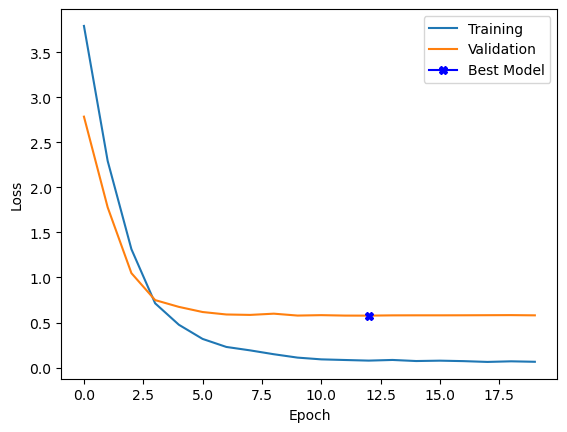

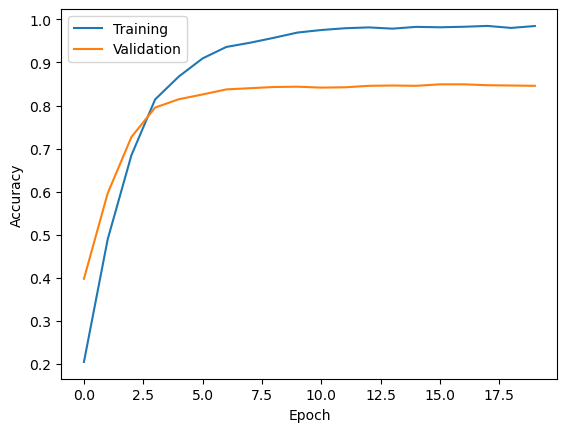

  0%|          | 0/12 [00:00<?, ?it/s]

Test Accuracy: 0.8513653646733494


In [ ]:
show_graphics(history)
test(net, test_dataloader, DEVICE)

#### Experiment 3

Use pre trained AlexNet, training on all the parameters (changing iper-parameters)

In [ ]:
# cahnging some iper-parameters
BATCH_SIZE = 128
LR = 1e-2
NUM_EPOCHS = 30
STEP_SIZE = 5  # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.1  # Multiplicative factor for learning rate step-down

train_dataloader, val_dataloader, test_dataloader = create_dataloaders(BATCH_SIZE)
net = get_alexnet(NUM_CLASSES, pretrained=True)
criterion, optimizer, scheduler = prepare_training(net, LR, MOMENTUM, WEIGHT_DECAY, STEP_SIZE, GAMMA, trainable='fc')

best_state_dict, history = training_and_validation(
    net, train_dataloader, val_dataloader, criterion, optimizer, scheduler, DEVICE, NUM_EPOCHS, pasience=7
)

# load best state of training
net.load_state_dict(best_state_dict)

  0%|          | 0/30 [00:00<?, ?it/s]

Starting epoch 1/30, LR = [0.01]
Training Loss: 1.702707, Training Accuracy: 0.616004
Validation Loss: 0.680810, Validation Accuracy: 0.808437
Starting epoch 2/30, LR = [0.01]
Training Loss: 0.288932, Training Accuracy: 0.911695
Validation Loss: 0.549917, Validation Accuracy: 0.840249
Starting epoch 3/30, LR = [0.01]
Training Loss: 0.116590, Training Accuracy: 0.969934
Validation Loss: 0.546740, Validation Accuracy: 0.852006
Starting epoch 4/30, LR = [0.01]
Training Loss: 0.073561, Training Accuracy: 0.982718
Validation Loss: 0.536691, Validation Accuracy: 0.841632
Starting epoch 5/30, LR = [0.01]
Training Loss: 0.051253, Training Accuracy: 0.987926
Validation Loss: 0.545099, Validation Accuracy: 0.855463
Starting epoch 6/30, LR = [0.001]
Training Loss: 0.028054, Training Accuracy: 0.993608
Validation Loss: 0.534414, Validation Accuracy: 0.856155
Starting epoch 7/30, LR = [0.001]
Training Loss: 0.023184, Training Accuracy: 0.996449
Validation Loss: 0.534799, Validation Accuracy: 0.8568

<All keys matched successfully>

Showing Results

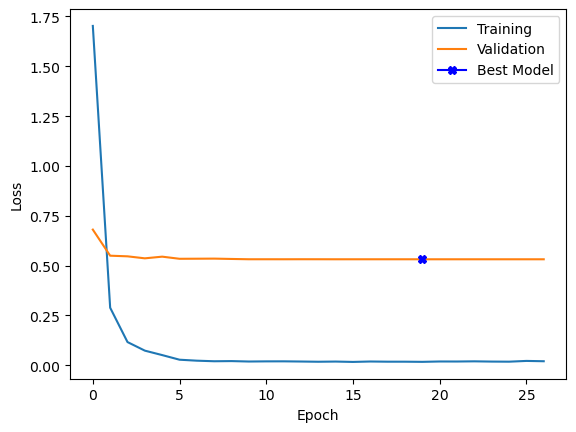

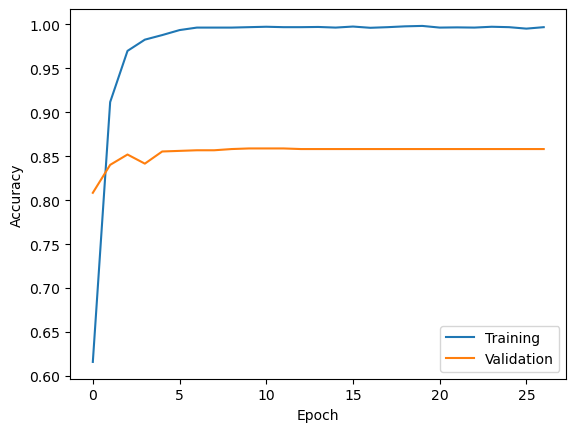

  0%|          | 0/23 [00:00<?, ?it/s]

Test Accuracy: 0.8672658140338748


In [ ]:
show_graphics(history)
test(net, test_dataloader, DEVICE)

#### Experiment 4

Use a pre trained AlexNet, Training only the convulational layers

In [ ]:
# changing some iper-parameters
BATCH_SIZE = 512
LR = 1e-2
NUM_EPOCHS = 30
STEP_SIZE = 10
GAMMA = 0.1

# initialitation of dataloader, net and training
train_dataloader, val_dataloader, test_dataloader = create_dataloaders(BATCH_SIZE)
net = get_alexnet(NUM_CLASSES, pretrained=True)
criterion, optimizer, scheduler = prepare_training(net, LR, MOMENTUM, WEIGHT_DECAY, STEP_SIZE, GAMMA, trainable='conv')

# training and validation
best_state_dict, history = training_and_validation(
    net, train_dataloader, val_dataloader, criterion, optimizer, scheduler, DEVICE, NUM_EPOCHS, pasience=7
)

# load best state of training
net.load_state_dict(best_state_dict)

  0%|          | 0/30 [00:00<?, ?it/s]

Starting epoch 1/30, LR = [0.01]
Training Loss: 4.648739, Training Accuracy: 0.025879
Validation Loss: 4.469900, Validation Accuracy: 0.055325
Starting epoch 2/30, LR = [0.01]
Training Loss: 4.358461, Training Accuracy: 0.097412
Validation Loss: 4.099524, Validation Accuracy: 0.187414
Starting epoch 3/30, LR = [0.01]
Training Loss: 3.983786, Training Accuracy: 0.189697
Validation Loss: 3.671428, Validation Accuracy: 0.242047
Starting epoch 4/30, LR = [0.01]
Training Loss: 3.655756, Training Accuracy: 0.237793
Validation Loss: 3.385681, Validation Accuracy: 0.276625
Starting epoch 5/30, LR = [0.01]
Training Loss: 3.455270, Training Accuracy: 0.271729
Validation Loss: 3.262248, Validation Accuracy: 0.298064
Starting epoch 6/30, LR = [0.01]
Training Loss: 3.288625, Training Accuracy: 0.300537
Validation Loss: 3.147354, Validation Accuracy: 0.331259
Starting epoch 7/30, LR = [0.01]
Training Loss: 3.206544, Training Accuracy: 0.314941
Validation Loss: 3.078011, Validation Accuracy: 0.339557

<All keys matched successfully>

Showing Results

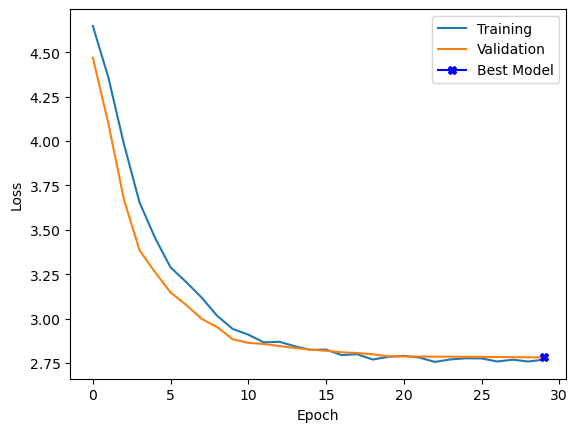

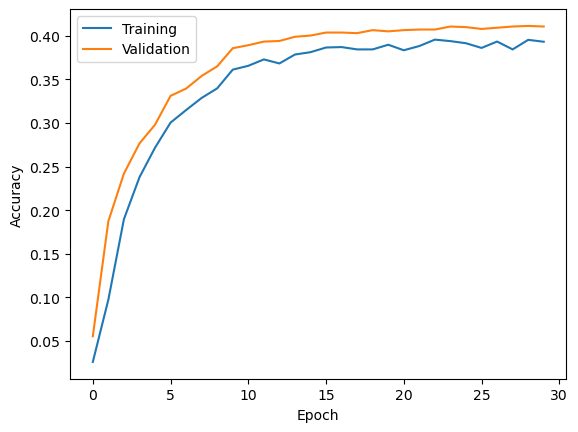

  0%|          | 0/6 [00:00<?, ?it/s]

Test Accuracy: 0.4165226408572416


In [ ]:
show_graphics(history)
test(net, test_dataloader, DEVICE)

#### Experiment 5

Use a pre trained AlexNet, Training only the classifier layers

In [ ]:
# changing some iper-parameters
BATCH_SIZE = 512
LR = 1e-2
NUM_EPOCHS = 30
STEP_SIZE = 10
GAMMA = 0.1

# initialitation of dataloader, net and training
train_dataloader, val_dataloader, test_dataloader = create_dataloaders(BATCH_SIZE)
net = get_alexnet(NUM_CLASSES, pretrained=True)
criterion, optimizer, scheduler = prepare_training(net, LR, MOMENTUM, WEIGHT_DECAY, STEP_SIZE, GAMMA, trainable='fc')

# training and validation
best_state_dict, history = training_and_validation(
    net, train_dataloader, val_dataloader, criterion, optimizer, scheduler, DEVICE, NUM_EPOCHS, pasience=7
)

# load best state of training
net.load_state_dict(best_state_dict)

  0%|          | 0/30 [00:00<?, ?it/s]

Starting epoch 1/30, LR = [0.01]
Training Loss: 3.227911, Training Accuracy: 0.319580
Validation Loss: 1.757505, Validation Accuracy: 0.606501
Starting epoch 2/30, LR = [0.01]
Training Loss: 1.244488, Training Accuracy: 0.709717
Validation Loss: 0.942556, Validation Accuracy: 0.762794
Starting epoch 3/30, LR = [0.01]
Training Loss: 0.572503, Training Accuracy: 0.855713
Validation Loss: 0.658892, Validation Accuracy: 0.824343
Starting epoch 4/30, LR = [0.01]
Training Loss: 0.353836, Training Accuracy: 0.905518
Validation Loss: 0.581957, Validation Accuracy: 0.838174
Starting epoch 5/30, LR = [0.01]
Training Loss: 0.235060, Training Accuracy: 0.934814
Validation Loss: 0.546475, Validation Accuracy: 0.843707
Starting epoch 6/30, LR = [0.01]
Training Loss: 0.170715, Training Accuracy: 0.954590
Validation Loss: 0.524200, Validation Accuracy: 0.852006
Starting epoch 7/30, LR = [0.01]
Training Loss: 0.127505, Training Accuracy: 0.967529
Validation Loss: 0.528729, Validation Accuracy: 0.852006

<All keys matched successfully>

Showing Results

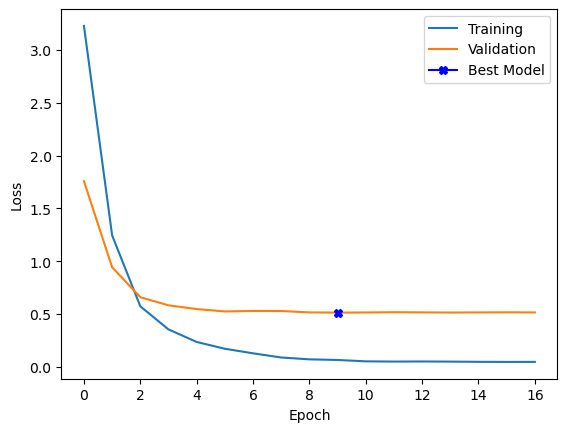

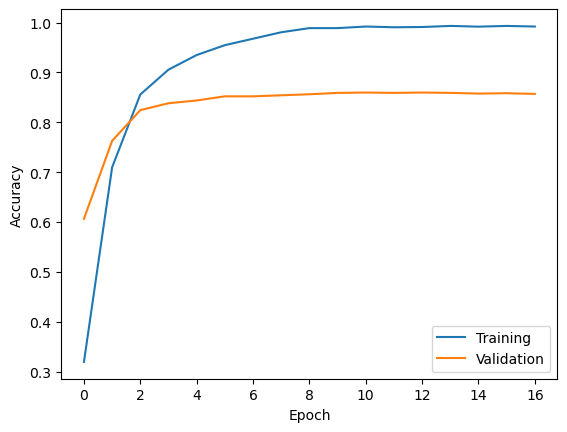

  0%|          | 0/6 [00:00<?, ?it/s]

Test Accuracy: 0.8613895610093328


In [ ]:
show_graphics(history)
test(net, test_dataloader, DEVICE)

### Data Augmentation

#### Geometric

In [ ]:
# Define transforms for training phase
train_transform = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.RandomRotation(10),  # random rotation (-10,10) grades
        transforms.RandomHorizontalFlip(0.2),  # random Horizonatal flip (20% of probability)
        transforms.CenterCrop(224),
        transforms.ToTensor(),  # Turn PIL Image to torch.Tensor
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
        ),  # Normalizes tensor with alex net preprocessing
    ]
)

In [ ]:
# changing some iper-parameters
BATCH_SIZE = 512
LR = 1e-2
NUM_EPOCHS = 30
STEP_SIZE = 10
GAMMA = 0.1

# initialitation of dataloader, net and training
train_dataloader, val_dataloader, test_dataloader = create_dataloaders(BATCH_SIZE)
net = get_alexnet(NUM_CLASSES, pretrained=True)
criterion, optimizer, scheduler = prepare_training(net, LR, MOMENTUM, WEIGHT_DECAY, STEP_SIZE, GAMMA, trainable='all')

# training and validation
best_state_dict, history = training_and_validation(
    net, train_dataloader, val_dataloader, criterion, optimizer, scheduler, DEVICE, NUM_EPOCHS, pasience=7
)

# load best state of training
net.load_state_dict(best_state_dict)

  0%|          | 0/30 [00:00<?, ?it/s]

Starting epoch 1/30, LR = [0.01]
Training Loss: 3.318805, Training Accuracy: 0.303223
Validation Loss: 1.970880, Validation Accuracy: 0.558091
Starting epoch 2/30, LR = [0.01]
Training Loss: 1.347399, Training Accuracy: 0.666260
Validation Loss: 0.852451, Validation Accuracy: 0.772476
Starting epoch 3/30, LR = [0.01]
Training Loss: 0.522510, Training Accuracy: 0.853760
Validation Loss: 0.637965, Validation Accuracy: 0.831950
Starting epoch 4/30, LR = [0.01]
Training Loss: 0.317212, Training Accuracy: 0.903320
Validation Loss: 0.588393, Validation Accuracy: 0.840249
Starting epoch 5/30, LR = [0.01]
Training Loss: 0.183604, Training Accuracy: 0.946777
Validation Loss: 0.595405, Validation Accuracy: 0.847856
Starting epoch 6/30, LR = [0.01]
Training Loss: 0.091448, Training Accuracy: 0.974609
Validation Loss: 0.638056, Validation Accuracy: 0.852697
Starting epoch 7/30, LR = [0.01]
Training Loss: 0.053731, Training Accuracy: 0.981934
Validation Loss: 0.659679, Validation Accuracy: 0.852697

<All keys matched successfully>

Showing Results

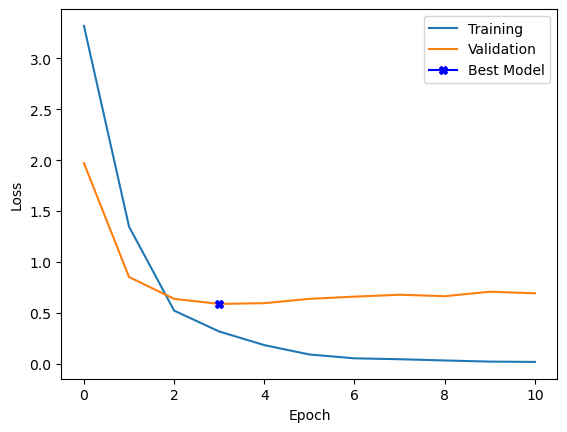

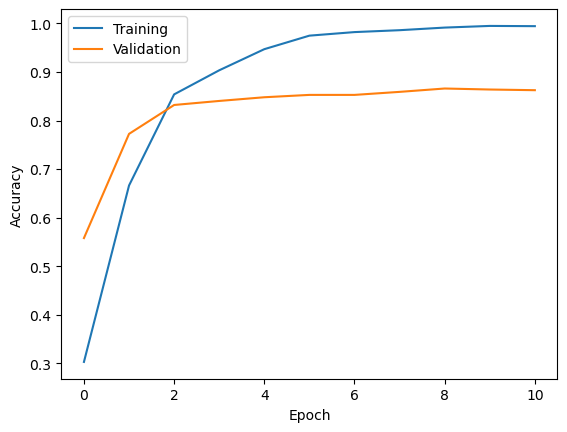

  0%|          | 0/6 [00:00<?, ?it/s]

Test Accuracy: 0.8568959557552713


In [ ]:
show_graphics(history)
test(net, test_dataloader, DEVICE)

#### Color

In [ ]:
# Define transforms for training phase
train_transform = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.ColorJitter(0.1, 0.1),  # randomly  change brightness and contrast [0.9, 1.1]
        transforms.CenterCrop(224),
        transforms.ToTensor(),  # Turn PIL Image to torch.Tensor
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
        ),  # Normalizes tensor with alex net preprocessing
    ]
)

In [ ]:
# initialitation of dataloader, net and training
train_dataloader, val_dataloader, test_dataloader = create_dataloaders(BATCH_SIZE)
net = get_alexnet(NUM_CLASSES, pretrained=True)
criterion, optimizer, scheduler = prepare_training(net, LR, MOMENTUM, WEIGHT_DECAY, STEP_SIZE, GAMMA, trainable='all')

# training and validation
best_state_dict, history = training_and_validation(
    net, train_dataloader, val_dataloader, criterion, optimizer, scheduler, DEVICE, NUM_EPOCHS, pasience=7
)

# load best state of training
net.load_state_dict(best_state_dict)

  0%|          | 0/30 [00:00<?, ?it/s]

Starting epoch 1/30, LR = [0.01]
Training Loss: 3.413590, Training Accuracy: 0.278076
Validation Loss: 2.097328, Validation Accuracy: 0.543568
Starting epoch 2/30, LR = [0.01]
Training Loss: 1.441046, Training Accuracy: 0.647217
Validation Loss: 0.990910, Validation Accuracy: 0.743430
Starting epoch 3/30, LR = [0.01]
Training Loss: 0.648259, Training Accuracy: 0.820068
Validation Loss: 0.664608, Validation Accuracy: 0.823651
Starting epoch 4/30, LR = [0.01]
Training Loss: 0.331614, Training Accuracy: 0.905518
Validation Loss: 0.547591, Validation Accuracy: 0.843707
Starting epoch 5/30, LR = [0.01]
Training Loss: 0.164221, Training Accuracy: 0.949707
Validation Loss: 0.604835, Validation Accuracy: 0.853389
Starting epoch 6/30, LR = [0.01]
Training Loss: 0.088328, Training Accuracy: 0.973389
Validation Loss: 0.581098, Validation Accuracy: 0.854080
Starting epoch 7/30, LR = [0.01]
Training Loss: 0.059241, Training Accuracy: 0.982910
Validation Loss: 0.618945, Validation Accuracy: 0.856155

<All keys matched successfully>

Showing Results

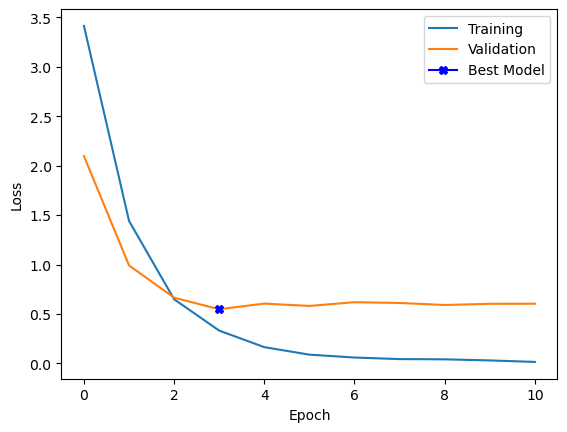

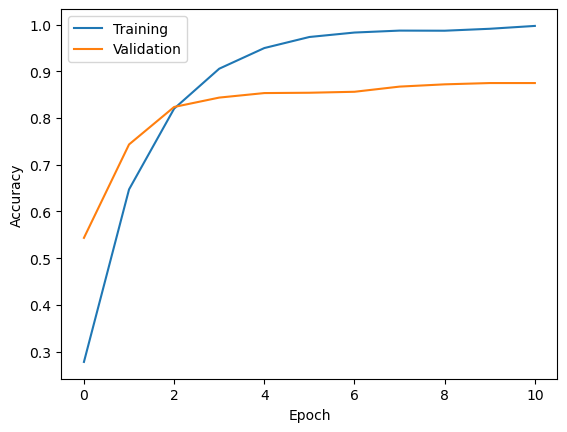

  0%|          | 0/6 [00:00<?, ?it/s]

Test Accuracy: 0.8638091946076737


In [ ]:
show_graphics(history)
test(net, test_dataloader, DEVICE)

#### Combined Geometric and Color

In [ ]:
# Define transforms for training phase
train_transform = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.RandomRotation(10),  # random rotation (-10,10) grades
        transforms.RandomHorizontalFlip(0.2),  # random Horizonatal flip (20% of probability)
        transforms.ColorJitter(0.1, 0.1),  # randomly  change brightness and contrast [0.9, 1.1]
        transforms.CenterCrop(224),
        transforms.ToTensor(),  # Turn PIL Image to torch.Tensor
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
        ),  # Normalizes tensor with alex net preprocessing
    ]
)

In [ ]:
# initialitation of dataloader, net and training
train_dataloader, val_dataloader, test_dataloader = create_dataloaders(BATCH_SIZE)
net = get_alexnet(NUM_CLASSES, pretrained=True)
criterion, optimizer, scheduler = prepare_training(net, LR, MOMENTUM, WEIGHT_DECAY, STEP_SIZE, GAMMA, trainable='all')

# training and validation
best_state_dict, history = training_and_validation(
    net, train_dataloader, val_dataloader, criterion, optimizer, scheduler, DEVICE, NUM_EPOCHS, pasience=7
)

# load best state of training
net.load_state_dict(best_state_dict)

  0%|          | 0/30 [00:00<?, ?it/s]

Starting epoch 1/30, LR = [0.01]
Training Loss: 3.347761, Training Accuracy: 0.298828
Validation Loss: 2.039801, Validation Accuracy: 0.566390
Starting epoch 2/30, LR = [0.01]
Training Loss: 1.391617, Training Accuracy: 0.655029
Validation Loss: 0.866975, Validation Accuracy: 0.778008
Starting epoch 3/30, LR = [0.01]
Training Loss: 0.555337, Training Accuracy: 0.845703
Validation Loss: 0.617621, Validation Accuracy: 0.829184
Starting epoch 4/30, LR = [0.01]
Training Loss: 0.302235, Training Accuracy: 0.908691
Validation Loss: 0.581633, Validation Accuracy: 0.836100
Starting epoch 5/30, LR = [0.01]
Training Loss: 0.164769, Training Accuracy: 0.948975
Validation Loss: 0.573329, Validation Accuracy: 0.852006
Starting epoch 6/30, LR = [0.01]
Training Loss: 0.104940, Training Accuracy: 0.969238
Validation Loss: 0.587687, Validation Accuracy: 0.849931
Starting epoch 7/30, LR = [0.01]
Training Loss: 0.064114, Training Accuracy: 0.978760
Validation Loss: 0.594447, Validation Accuracy: 0.861687

<All keys matched successfully>

Showing Results

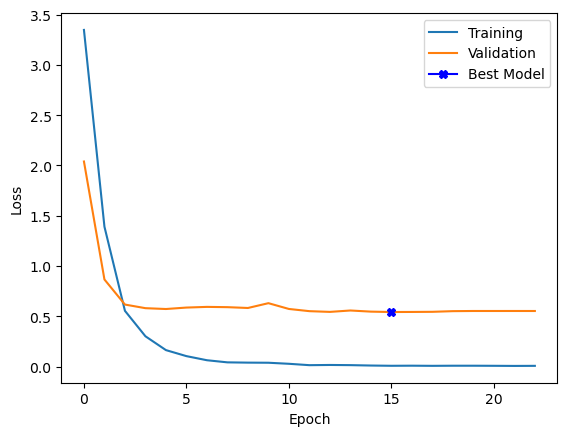

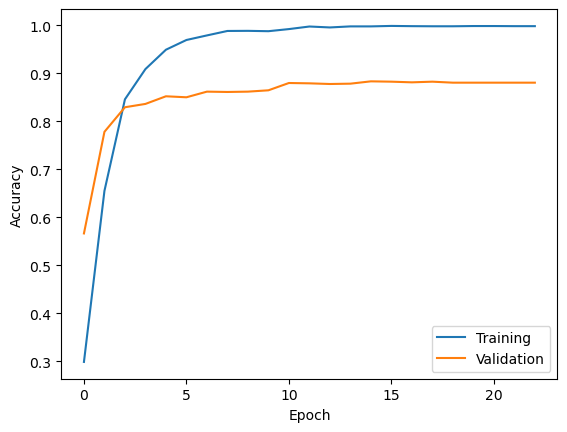

  0%|          | 0/6 [00:00<?, ?it/s]

Test Accuracy: 0.8638091946076737


In [ ]:
show_graphics(history)
test(net, test_dataloader, DEVICE)

### Others Networks

#### ResNet50

In [11]:
def get_resenet50(num_classes, pretrained=True):
    if pretrained:
        net = resnet50(weights='DEFAULT')
    else:
        net = resnet50()
    net.fc = nn.Linear(net.fc.in_features, num_classes)
    return net

In [12]:
# changing some iper-parameters
BATCH_SIZE = 64
LR = 1e-3
NUM_EPOCHS = 30
STEP_SIZE = 10
GAMMA = 0.1

# initialitation of dataloader, net and training
train_dataloader, val_dataloader, test_dataloader = create_dataloaders(BATCH_SIZE)
net = get_resenet50(NUM_CLASSES, pretrained=True)
criterion, optimizer, scheduler = prepare_training(net, LR, MOMENTUM, WEIGHT_DECAY, STEP_SIZE, GAMMA, trainable='all')

# training and validation
best_state_dict, history = training_and_validation(
    net, train_dataloader, val_dataloader, criterion, optimizer, scheduler, DEVICE, NUM_EPOCHS, pasience=7
)

# load best state of training
net.load_state_dict(best_state_dict)

  0%|          | 0/30 [00:00<?, ?it/s]

Starting epoch 1/30, LR = [0.001]
Training Loss: 4.002885, Training Accuracy: 0.217584
Validation Loss: 3.299859, Validation Accuracy: 0.300830
Starting epoch 2/30, LR = [0.001]
Training Loss: 3.041648, Training Accuracy: 0.383162
Validation Loss: 2.815767, Validation Accuracy: 0.525588
Starting epoch 3/30, LR = [0.001]
Training Loss: 2.465986, Training Accuracy: 0.603545
Validation Loss: 2.166291, Validation Accuracy: 0.679806
Starting epoch 4/30, LR = [0.001]
Training Loss: 1.780524, Training Accuracy: 0.718517
Validation Loss: 1.476140, Validation Accuracy: 0.773859
Starting epoch 5/30, LR = [0.001]
Training Loss: 1.164383, Training Accuracy: 0.810868
Validation Loss: 0.948550, Validation Accuracy: 0.841632
Starting epoch 6/30, LR = [0.001]
Training Loss: 0.736341, Training Accuracy: 0.882463
Validation Loss: 0.647122, Validation Accuracy: 0.891425
Starting epoch 7/30, LR = [0.001]
Training Loss: 0.500956, Training Accuracy: 0.928638
Validation Loss: 0.482552, Validation Accuracy: 0

<All keys matched successfully>

Showing Results

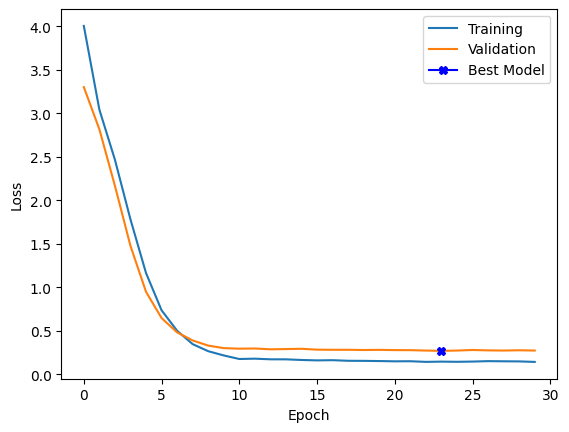

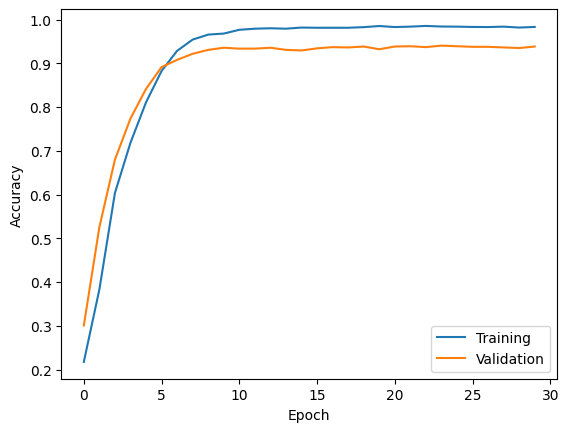

  0%|          | 0/46 [00:00<?, ?it/s]

Test Accuracy: 0.9422744555824404


In [13]:
show_graphics(history)
test(net, test_dataloader, DEVICE)

#### Vgg16

In [16]:
def get_vgg16(num_classes, pretrained=True):
    if pretrained:
        net = vgg16(weights='DEFAULT')
    else:
        net = vgg16()
    net.classifier[6] = nn.Linear(net.classifier[6].in_features, num_classes)
    return net

In [19]:
# changing some iper-parameters
BATCH_SIZE = 64
LR = 1e-3
NUM_EPOCHS = 30
STEP_SIZE = 10
GAMMA = 0.1

# initialitation of dataloader, net and training
train_dataloader, val_dataloader, test_dataloader = create_dataloaders(BATCH_SIZE)
net = get_vgg16(NUM_CLASSES, pretrained=True)
criterion, optimizer, scheduler = prepare_training(net, LR, MOMENTUM, WEIGHT_DECAY, STEP_SIZE, GAMMA, trainable='all')

# training and validation
best_state_dict, history = training_and_validation(
    net, train_dataloader, val_dataloader, criterion, optimizer, scheduler, DEVICE, NUM_EPOCHS, pasience=7
)

# load best state of training
net.load_state_dict(best_state_dict)

  0%|          | 0/30 [00:00<?, ?it/s]

Starting epoch 1/30, LR = [0.001]
Training Loss: 2.598962, Training Accuracy: 0.429338
Validation Loss: 0.730338, Validation Accuracy: 0.793223
Starting epoch 2/30, LR = [0.001]
Training Loss: 0.614983, Training Accuracy: 0.832090
Validation Loss: 0.402794, Validation Accuracy: 0.881051
Starting epoch 3/30, LR = [0.001]
Training Loss: 0.267432, Training Accuracy: 0.922108
Validation Loss: 0.328191, Validation Accuracy: 0.905256
Starting epoch 4/30, LR = [0.001]
Training Loss: 0.153279, Training Accuracy: 0.950793
Validation Loss: 0.310345, Validation Accuracy: 0.909405
Starting epoch 5/30, LR = [0.001]
Training Loss: 0.093490, Training Accuracy: 0.969683
Validation Loss: 0.289735, Validation Accuracy: 0.919087
Starting epoch 6/30, LR = [0.001]
Training Loss: 0.075679, Training Accuracy: 0.976679
Validation Loss: 0.322572, Validation Accuracy: 0.916321
Starting epoch 7/30, LR = [0.001]
Training Loss: 0.057602, Training Accuracy: 0.983442
Validation Loss: 0.299432, Validation Accuracy: 0

<All keys matched successfully>

Showing Results

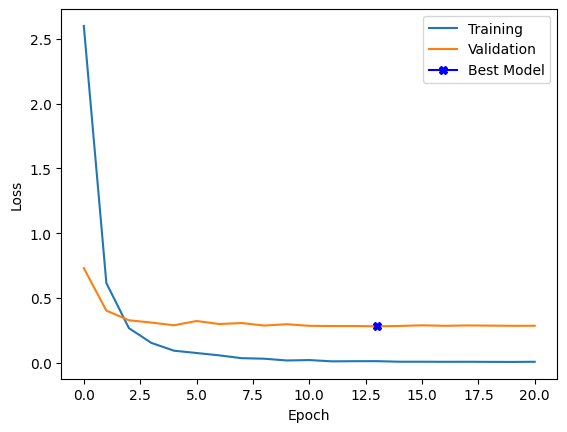

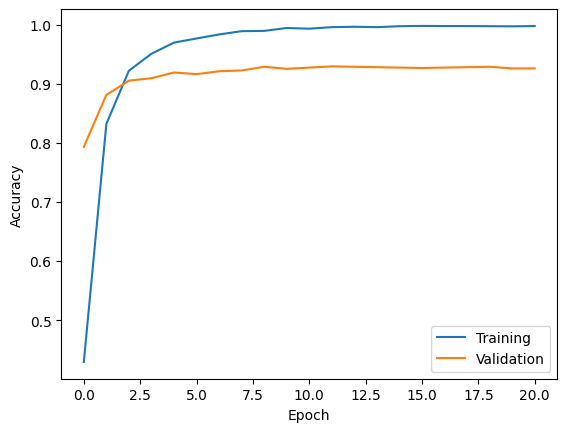

  0%|          | 0/46 [00:00<?, ?it/s]

Test Accuracy: 0.9319045973038369


In [20]:
show_graphics(history)
test(net, test_dataloader, DEVICE)